## Summaries: 
-------------------
### * Neural network model is trained to predict Cancer Type. The accuracy is about 0.3, better than baseline (0.08).
### * Three explanatory variables - Age, Height, Medication -  is procressed and cleaned.
### * One third Sex is missing. 
-------------------


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split
import tensorflow as tf
import math
from sklearn.svm import SVC, LinearSVC

## read data and overview

In [2]:
df = pd.read_csv('patients.txt', delimiter = "\t")
df.head()

In [3]:
df.dtypes

patient_id       int64
cancer_type     object
age              int64
height(in)       int64
primary_site    object
sex             object
medication      object
dtype: object

In [4]:
df.describe()

,patient_id,age,height(in)
count,10086.000000,10086.000000,10086.000000
mean,5994.338786,50.074261,42.055126
std,2316.591112,29.286063,24.115664
min,2002.000000,-10.000000,1.000000
25%,3977.000000,24.000000,21.000000
50%,5997.000000,51.000000,42.000000
75%,7988.000000,75.000000,63.000000
max,10000.000000,100.000000,84.000000


In [5]:
df.describe(include=['object'])

,cancer_type,primary_site,sex,medication
count,10086,10086,6785,10086
unique,20,19,2,32
top,cervix,cervical cancer,female,Dacarbazine
freq,812,797,3428,438


In [6]:
df.isnull().sum()

patient_id         0
cancer_type        0
age                0
height(in)         0
primary_site       0
sex             3301
medication         0
dtype: int64

----------
the target variable is cancer_type, a categorical variable. <br>
we have five explanatory variables: <br>
two numeric variables : age and height(in); <br>
two categorical variables : sex, medication.

----------

## data cleaning

### one var - cancer_type (targer variable)

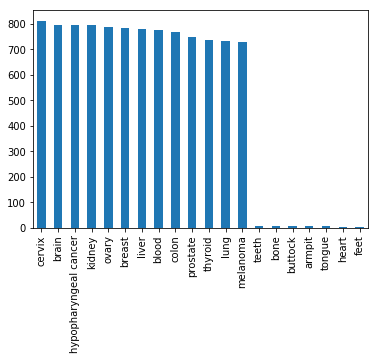

In [7]:
df['cancer_type'].value_counts().plot.bar()

In [8]:
df['cancer_type'].value_counts()

cervix                   812
brain                    797
hypopharyngeal cancer    796
kidney                   795
ovary                    786
breast                   785
liver                    778
blood                    777
colon                    768
prostate                 747
thyroid                  738
lung                     734
melanoma                 728
teeth                      9
bone                       8
buttock                    8
armpit                     7
tongue                     7
heart                      4
feet                       2
Name: cancer_type, dtype: int64

----------
there are two groups of cancers: common cancers and rare cancers.

----------

### one var - age

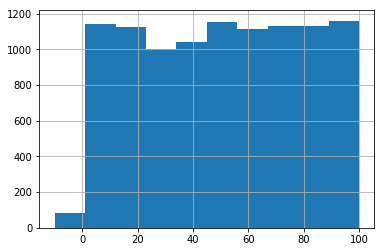

In [9]:
df['age'].hist()

----------
we find some unreasonable negative values.

----------

### one var - height(in)

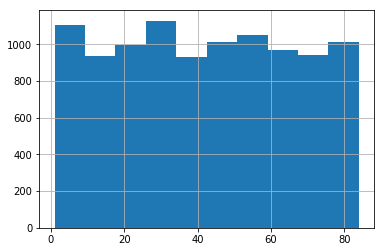

In [10]:
df['height(in)'].hist()

----------
we find some unreasonable low values.

----------

### one var - primary_site

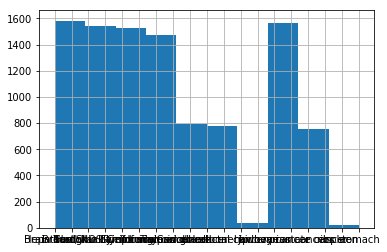

In [11]:
df['primary_site'].hist()

----------
although we will not use primary_site to built model, we still take a look at primary_site. We see that some primary sites have fewer data points.

----------


### one var - sex

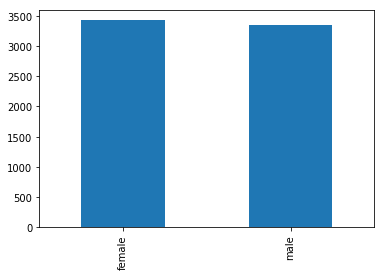

In [12]:
df['sex'].value_counts().plot.bar()

In [13]:
df['sex'].value_counts()

female    3428
male      3357
Name: sex, dtype: int64

----------
even though the distribution of sex is reasonabl, lots of missing data would be a problem needed to deal with.

----------


### one var - medication

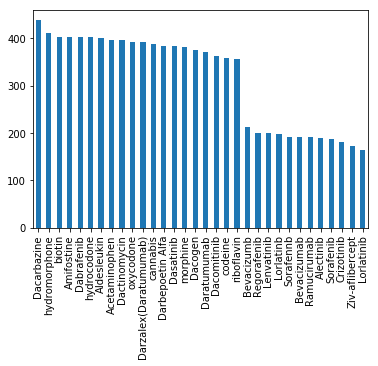

In [14]:
df['medication'].value_counts().plot.bar()

In [15]:
df['medication'].value_counts().sort_index()

Acetaminophen            397
Aldesleukin              400
Alectinib                190
Amifostine               404
Bevacizumab              192
Bevacizumb               212
Crizotinib               182
Dabrafenib               403
Dacarbazine              438
Dacogen                  375
Dacomitinib              362
Dactinomycin             396
Daratumumab              372
Darbepoetin Alfa         385
Darzalex(Daratumumab)    392
Dasatinib                385
Lenvatinib               199
Lorlatinb                198
Lorlatinib               164
Ramucirumab              191
Regorafenib              200
Sorafenib                187
Sorafennb                192
Ziv-aflibercept          173
biotin                   404
cannabis                 389
codeine                  358
hydrocodone              403
hydromorphone            412
morphine                 381
oxycodone                393
riboflavin               357
Name: medication, dtype: int64

----------
some medications are duplicated or typo, so we need to eliminate them.
<br>
Bevacizumab & Bevacizumb <br>
Daratumumab & Darzalex(Daratumumab) <br>
Lorlatinb & Lorlatinib <br>
Sorafenib & Sorafennb

----------

### deal with error and anomaly 

let's replace errors and anomalies with accurate data or just use NaN. <br>
we replace negative age values with NaN. <br>
average height of infants is about 19 to 20 in., so we replace all values lower than the average height with NaN. <br>
we also handle duplicated medications.

In [16]:
df['new_age'] = np.where(df['age']>=0, df['age'], np.NaN)
df['new_ht'] = np.where(df['height(in)']>=20, df['height(in)'], np.NaN)
df['new_med'] = np.where(df['medication']=='Bevacizumb', 'Bevacizumab', df['medication'])
df['new_med'] = np.where(df['new_med']=='Darzalex(Daratumumab)', 'Daratumumab', df['new_med'])
df['new_med'] = np.where(df['new_med']=='Lorlatinb', 'Lorlatinib', df['new_med'])
df['new_med'] = np.where(df['new_med']=='Sorafennb', 'Sorafenib', df['new_med'])

In [17]:
df.describe()

,patient_id,age,height(in),new_age,new_ht
count,10086.000000,10086.000000,10086.000000,10002.000000,7769.000000
mean,5994.338786,50.074261,42.055126,50.539592,51.602265
std,2316.591112,29.286063,24.115664,28.962317,18.686251
min,2002.000000,-10.000000,1.000000,1.000000,20.000000
25%,3977.000000,24.000000,21.000000,25.000000,35.000000
50%,5997.000000,51.000000,42.000000,51.000000,51.000000
75%,7988.000000,75.000000,63.000000,76.000000,68.000000
max,10000.000000,100.000000,84.000000,100.000000,84.000000


In [18]:
df['new_med'].value_counts().sort_index()

Acetaminophen       397
Aldesleukin         400
Alectinib           190
Amifostine          404
Bevacizumab         404
Crizotinib          182
Dabrafenib          403
Dacarbazine         438
Dacogen             375
Dacomitinib         362
Dactinomycin        396
Daratumumab         764
Darbepoetin Alfa    385
Dasatinib           385
Lenvatinib          199
Lorlatinib          362
Ramucirumab         191
Regorafenib         200
Sorafenib           379
Ziv-aflibercept     173
biotin              404
cannabis            389
codeine             358
hydrocodone         403
hydromorphone       412
morphine            381
oxycodone           393
riboflavin          357
Name: new_med, dtype: int64

### output cleaned dataset

In [19]:
new_df = df[['new_age', 'new_ht', 'sex', 'new_med', 'cancer_type']]
new_df.head()

,new_age,new_ht,sex,new_med,cancer_type
0,44.0,NaN,NaN,Dabrafenib,blood
1,77.0,NaN,NaN,hydrocodone,blood
2,64.0,42.0,female,oxycodone,brain
3,57.0,NaN,NaN,Bevacizumab,colon
4,20.0,NaN,female,Amifostine,cervix


In [20]:
new_df.isnull().sum()

new_age          84
new_ht         2317
sex            3301
new_med           0
cancer_type       0
dtype: int64

In [21]:
new_df.to_csv('c_df.csv', sep='\t')

## Model Fitting - Classifiction

before fitting model, we need to convert categorical variable to one-hot encoding, and normalize values of numaric variables.

In [22]:
# normalize value to 0~1 by min max
df_oh_nor = new_df.copy()
df_oh_nor['nor_age'] = (df_oh_nor['new_age'] - df_oh_nor['new_age'].min())/(df_oh_nor['new_age'].max()-df_oh_nor['new_age'].min())
df_oh_nor['nor_ht'] = (df_oh_nor['new_ht'] - df_oh_nor['new_ht'].min())/(df_oh_nor['new_ht'].max() - df_oh_nor['new_ht'].min())
# one-hot encoding
df_oh_nor = pd.get_dummies(df_oh_nor, dummy_na=True)

we drop out NaN to get a preliminary result. (NaN can be replaced by stat estimation, which is skipped here.)

In [23]:
df_pro = df_oh_nor.iloc[:, 2:].dropna()
df_pro.to_csv('df_pro.csv', sep='\t')

In [24]:
X = df_pro.iloc[:, :-21]
y = df_pro.iloc[:, -20:]  
print('X.shape', X.shape, '\ny.shape', y.shape)

X.shape (7702, 34) 
y.shape (7702, 20)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 
print('X_train.shape', X_train.shape, 'X_test.shape', X_test.shape, \
      '\ny_train.shape', y_train.shape, 'y_test.shape', y_test.shape)

X_train.shape (6161, 34) X_test.shape (1541, 34) 
y_train.shape (6161, 20) y_test.shape (1541, 20)


### Neural Network

### prepare nn structure

In [26]:
# Build NN
LEARNING_RATE = 0.0001

is_training = True

initializer = tf.contrib.layers.variance_scaling_initializer()

x = tf.placeholder(tf.float32, [None, 34])
y_ = tf.placeholder(tf.float32, [None, 20])

l1 = tf.layers.dense(x, units=128,  activation=tf.nn.relu, kernel_initializer=initializer)
l2 = tf.layers.dense(l1, units=128, activation=tf.nn.relu, kernel_initializer=initializer)
l3 = tf.contrib.layers.layer_norm(l2)
l4 = tf.layers.dropout(l3, rate=0.2, training=is_training)
l5 = tf.layers.dense(l4, units=128,  activation=tf.nn.relu, kernel_initializer=initializer)
l6 = tf.contrib.layers.layer_norm(l5)
l7 = tf.layers.dense(l6, units=128,  activation=tf.nn.relu, kernel_initializer=initializer)
l8 = tf.contrib.layers.layer_norm(l7)
l9 = tf.layers.dense(l8, units=20,  activation=tf.nn.relu, kernel_initializer=initializer)
y = tf.nn.softmax(l9, name='y')

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=y))
train_step = tf.train.AdamOptimizer(LEARNING_RATE).minimize(loss)

correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

sess=tf.Session()
tf.global_variables_initializer().run(session=sess)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


### train and predcit

In [27]:
BATCH_SIZE = 256

# mini-batch data
train_data = tf.data.Dataset.from_tensor_slices(tf.constant(X_train))
label_data = tf.data.Dataset.from_tensor_slices(tf.constant(y_train))
zip_data = tf.data.Dataset.zip((train_data, label_data))

batch_data = zip_data.batch(BATCH_SIZE)
batch_data = batch_data.repeat()
iterator = batch_data.make_one_shot_iterator()
next_batch = iterator.get_next()

In [28]:
# Training

train_steps = 40000

for i in range(train_steps+1):
    batch = sess.run(next_batch)
    _, loss_value = sess.run((train_step, loss), feed_dict={x: batch[0], y_: batch[1]})
    if i% 2000 == 0:
        acc = sess.run(accuracy, feed_dict={x: X_test, y_: y_test})
        print('Training Step:' + str(i) + '  Loss =  ' + str(loss_value) + ' Accuracy : ' + str(acc))

Training Step:0  Loss =  3.0029552 Accuracy : 0.046722908
Training Step:2000  Loss =  2.7116055 Accuracy : 0.3127839
Training Step:4000  Loss =  2.689166 Accuracy : 0.31992212
Training Step:6000  Loss =  2.6757872 Accuracy : 0.32900715
Training Step:8000  Loss =  2.6649878 Accuracy : 0.32251784
Training Step:10000  Loss =  2.6481757 Accuracy : 0.32706034
Training Step:12000  Loss =  2.639464 Accuracy : 0.32511356
Training Step:14000  Loss =  2.6187522 Accuracy : 0.31602857
Training Step:16000  Loss =  2.6161046 Accuracy : 0.32186893
Training Step:18000  Loss =  2.6227453 Accuracy : 0.32576248
Training Step:20000  Loss =  2.6189313 Accuracy : 0.3173264
Training Step:22000  Loss =  2.6098108 Accuracy : 0.32121998
Training Step:24000  Loss =  2.6045227 Accuracy : 0.32446462
Training Step:26000  Loss =  2.61019 Accuracy : 0.3192732
Training Step:28000  Loss =  2.5929325 Accuracy : 0.32251784
Training Step:30000  Loss =  2.6042776 Accuracy : 0.31862426
Training Step:32000  Loss =  2.5883124

the accuracy is about 0.3, higher than baselin (guessing). however, the result is not satisfying, we can improve it by dealing with NaN, increasing sample size, etc.